In [1]:
using OpenQuantumTools
using LinearAlgebra
using OpenQuantumBase
using QuantumOptics
using OrdinaryDiffEq
using AVQD
using Plots
using CollectiveSpins
using QuantumOptics
# using PyPlot
using VarStructs
using Logging
using Suppressor
using LinearAlgebra

In [2]:
@var struct Spin_obj_template
    no_spins::Int64
    no_exc::Int64
    spin_type::Union{Int64,Float64}
    transition_omega::Union{Int64,Float64}
    geom_type::String
    lat_const::Union{Int64,Float64}   # in units of (transition omega)^-1 i.e. proportional to (c*k_0)^-1
end


function spin_object_constructor(no_spins::Int64, no_exc::Int64, spin_type::Union{Int64,Float64},
    transition_omega::Union{Int64,Float64}, geom_type::String, lat_const::Union{Int64,Float64})::Spin_obj_template

    N = no_spins
    full_exc = "True"

    if (full_exc == "True")
        M = N # Number of excitations 
    else
        M = no_exc
    end

    S = spin_type
    d_by_k0 = lat_const
    geom_type = geom_type

    Spin_obj = Spin_obj_template(no_spins=N, no_exc=M, spin_type=S,
        transition_omega=transition_omega,
        geom_type=geom_type, lat_const=d_by_k0)

    #println(N,M,d_by_k0)
    Spin_obj = Lattice_constructor(Spin_obj)
    return Spin_obj
end


function Lattice_constructor(Spin_obj::Spin_obj_template)::Spin_obj_template
    N = Spin_obj.no_spins
    M = Spin_obj.no_exc # Number of excitations
    d = Spin_obj.lat_const
    #println(N,M,d)
    #pos = geometry.chain(d,N)
    if Spin_obj.geom_type == "square"
        Spin_obj.pos_array = geometry.square(d; Nx=Int(sqrt(N)), Ny=Int(sqrt(N)))
    elseif Spin_obj.geom_type == "chain"
        Spin_obj.pos_array = geometry.chain(d, N)
    elseif Spin_obj.geom_type == "rectangle"
        println("Enter no_spins along x ")
        Nx = Int(readlines())
        #Nx = 2
        println("Enter no_spins along y ")
        Ny = Int(readlines())
        #Ny = 3
        d_1 = d
        d_2 = 2.0d
        Spin_obj.pos_array = geometry.rectangle(d_1, d_2; Nx=Int(Nx), Ny=Int(Ny))
    end
    Spin_obj.mu = [[1.0, 0, 0] for i = 1:N]   # lattice polarization
    Spin_obj.collection = SpinCollection(Spin_obj.pos_array, Spin_obj.mu)   # lattice positions
    Spin_obj.Omega_mat = OmegaMatrix(Spin_obj.collection)
    Spin_obj.Gamma_mat = GammaMatrix(Spin_obj.collection)
    # Hilbert space
    Spin_obj.basis_atom = SpinBasis(Spin_obj.spin_type) # Basis up to M excitations
    return Spin_obj
end


function spin_collection_op(Spin_obj::Spin_obj_template, i::Int64)::Vector{Operator}
    N = Spin_obj.no_spins
    Spin_obj.basis_ensemble = tensor([Spin_obj.basis_atom for m = 1:N]...)
    sm = embed(Spin_obj.basis_ensemble, i, sigmam(Spin_obj.basis_atom))
    sp = embed(Spin_obj.basis_ensemble, i, sigmap(Spin_obj.basis_atom))
    sz = embed(Spin_obj.basis_ensemble, i, sigmaz(Spin_obj.basis_atom))
    return [sm, sp, sz]
end
function Ham_and_state_constructor(Spin_obj::Spin_obj_template)::Spin_obj_template
    N = Spin_obj.no_spins
    M = Spin_obj.no_exc # Number of excitations
    d = Spin_obj.lat_const

    Operator_sm_array = []
    Operator_sp_array = []
    Operator_sz_array = []
    #sigma_p_sigma_m = [reducedsigmapsigmam(basis, i, j) for i=1:N, j=1:N]
    for i in 1:N
        temp_op = spin_collection_op(Spin_obj, i)
        push!(Operator_sm_array, temp_op[1])
        push!(Operator_sp_array, temp_op[2])
        push!(Operator_sz_array, temp_op[3])
    end

    Spin_obj.H_eff = sum((Spin_obj.Omega_mat[i, j]) * (Operator_sp_array[i] * Operator_sm_array[j]) for i = 1:N, j = 1:N) +
                     sum((Spin_obj.transition_omega) * (Operator_sp_array[i] * Operator_sm_array[i]) for i = 1:N)

    return Spin_obj
end

function diagonal_jump_operators(Spin_obj::Spin_obj_template)::Spin_obj_template
    N = Spin_obj.no_spins
    M = Spin_obj.no_exc # Number of excitations
    d = Spin_obj.lat_const
    sigma_i_m_op = [spin_collection_op(Spin_obj, i)[1] for i = 1:N]
    temp_ops = diagonaljumps(Spin_obj.Gamma_mat, sigma_i_m_op)
    Spin_obj.gamma_diag, Spin_obj.J_diag = temp_ops[1], temp_ops[2]
    return Spin_obj
end




function op_vs_t(Spin_obj::Spin_obj_template, rho)::Tuple{Vector{Float64},Vector{Float64},Vector{Float64},Vector{Float64}}
    N = Spin_obj.no_spins
    #basis = ReducedSpinBasis(no_spins,no_exc) # Basis up to M excitations
    Operator_sz_array = []
    #Operator_sm_array = []
    #Operator_sp_array = []
    for i in 1:N
        temp_op = spin_collection_op(Spin_obj, i)
        #push!(Operator_sm_array, temp_op[1])
        #push!(Operator_sp_array,temp_op[2])
        push!(Operator_sz_array, temp_op[3])
    end
    prop_z_avg = real(expect(sum([Operator_sz_array[i] for i = 1:N]), rho))

    prop_g2 = real(expect(sum((Spin_obj.gamma_diag[i] * Spin_obj.gamma_diag[j]) *
                              (dagger(Spin_obj.J_diag[i]) * dagger(Spin_obj.J_diag[j]) * Spin_obj.J_diag[j] * Spin_obj.J_diag[i]) for i = 1:N, j = 1:N), rho)) ./
              (real(expect(sum((Spin_obj.gamma_diag[i]) * (dagger(Spin_obj.J_diag[i]) * Spin_obj.J_diag[i]) for i = 1:N), rho))) .^ 2

    prop_emiss = real(expect(sum((Spin_obj.gamma_diag[i]) * (dagger(Spin_obj.J_diag[i]) * Spin_obj.J_diag[i]) for i = 1:N), rho))
    prop_Pop_ee = real(expect(sum([spin_collection_op(Spin_obj, i)[2] * spin_collection_op(Spin_obj, i)[1] for i in 1:N]), rho))

    prop_gamma_instant = prop_emiss ./ prop_Pop_ee
    #prop_gamma_instant = prop_Pop_ee
    #println(prop_g2)
    return prop_z_avg, prop_emiss, prop_g2, prop_gamma_instant
end

function time_evolution_master(Spin_obj::Spin_obj_template, time_list::Vector{Float64}, initial_state::Ket,
    type_of_evol::String)

    #::Tuple{Vector{Float64}, Union{Vector{Ket},Vector{Operator}},
    # Vector{Float64}, Vector{Float64}, Vector{Float64}}

    if type_of_evol == "master_eqn"
        time_list_out, rho = @suppress timeevolution.master(time_list, initial_state, Spin_obj.H_eff, Spin_obj.J_diag;
            rates=Spin_obj.gamma_diag)
        prop_z_avg, prop_emiss, prop_g2, prop_gamma_instant = op_vs_t(Spin_obj, rho)
        return time_list_out, rho, prop_z_avg, prop_emiss, prop_g2, prop_gamma_instant

    elseif type_of_evol == "MCWF"
        time_list_out, state = @suppress timeevolution.mcwf(time_list, initial_state, Spin_obj.H_eff, Spin_obj.J_diag;
            rates=Spin_obj.gamma_diag)
        prop_z_avg, prop_emiss, prop_g2, prop_gamma_instant = op_vs_t(Spin_obj, state)
        return time_list_out, state
    end
end

time_evolution_master (generic function with 1 method)

InteractionSet with 3

 interactionsInteractionSet with 3 interactionsInteractionSet with 3 interactions

InteractionSet with 3 interactionsInteractionSet with 3 interactionsInteractionSet with 3 interactions

InteractionSet with 3 interactionsInteractionSet with 3 interactionsInteractionSet with 3

 interactions

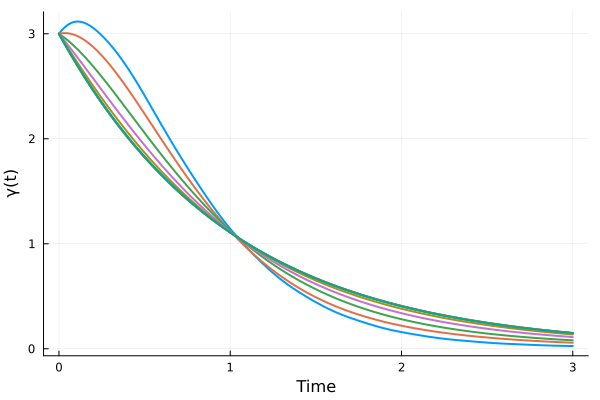

In [51]:
excited_e =[] # zeros(Float64, 9)

for sc in 1:9
    No_spins = 3
    N = No_spins
    No_exc = No_spins
    spin_type = 1 / 2
    spin_geom = "chain"
    lat_const = 0.1 * sc
    transition_omega = 2 * pi
    Spin_system_object = spin_object_constructor(No_spins, No_exc, spin_type, transition_omega, spin_geom, lat_const);
    Spin_system_object = Ham_and_state_constructor(Spin_system_object)
    Spin_system_object = diagonal_jump_operators(Spin_system_object)

    H = Matrix(Spin_system_object.H_eff.data)

    tf = 3.0
    dt = 0.01
    u0 = zeros(ComplexF64, 2^N, 2^N) #[1.0+0im 0 0 0;0 0 0 0; 0 0 0 0; 0 0 0 0]
    u0[1, 1] = 1.0 + 0im

    H = Hamiltonian([(s) -> 1.0], [H], unit=:ħ)

    Gamma = Matrix(Spin_system_object.Gamma_mat)
    γ = Spin_system_object.gamma_diag
    L = [Matrix(Spin_system_object.J_diag[i].data) for i in 1:N]
    linds = [Lindblad(γ[i], L[i]) for i in 1:N]
    linds = InteractionSet(linds...)

    annealing = Annealing(H, u0, interactions=linds)
    sol = solve_lindblad(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6, saveat=0:dt:tf)
    # print(length(sol.u[1]))
    steps = Integer(tf / dt)
    excited = [Float64(real(sol.u[i][1])) for i in 1:steps]
    ground = [Float64(real(sol.u[i][2^(2N)])) for i in 1:steps]

    times = LinRange(0, tf, steps)
    Plots.plot(times, excited, label="Excited State", xlabel="Time(s)", ylabel="Amplitude", linewidth=2)
    plot!(times, ground, label="Ground State", linewidth=2)
    steps = Integer(tf / dt)

    Spin_obj = Spin_system_object
    rho = sol.u
    prop_emiss = zeros(Float64, steps)
    prop_Pop_ee = zeros(Float64, steps)

    for j in 1:steps
        prop_emiss[j] = real(tr(sum((Spin_obj.gamma_diag[i]) * (dagger(Spin_obj.J_diag[i]) * Spin_obj.J_diag[i]) for i = 1:N).data * sol.u[j]))
        prop_Pop_ee[j] = real(tr(sum([spin_collection_op(Spin_obj, i)[2] * spin_collection_op(Spin_obj, i)[1] for i in 1:N]).data * sol.u[j]))
    end

    prop_gamma_instant = prop_emiss #./ prop_Pop_ee


    # print(steps)
    push!(excited_e,[prop_gamma_instant[i] for i in 1:steps])
end
tf = 3.0
dt = 0.01
steps = Integer(tf / dt)


times = LinRange(0, tf, steps)
Plots.plot(times, excited_e[:], label="", xlabel="Time", ylabel="γ(t)", linewidth=2)

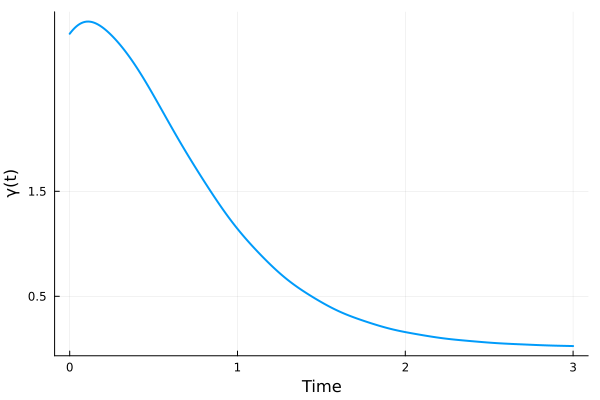

In [41]:

    No_spins = 3
    N = No_spins
    No_exc = No_spins
    spin_type = 1 / 2
    spin_geom = "chain"
    lat_const = 0.1
    transition_omega = 2 * pi
    Spin_system_object = spin_object_constructor(No_spins, No_exc, spin_type, transition_omega, spin_geom, lat_const)
    Spin_system_object = Ham_and_state_constructor(Spin_system_object)
    Spin_system_object = diagonal_jump_operators(Spin_system_object)

    H = Matrix(Spin_system_object.H_eff.data)

    tf = 3.00
    dt = 0.01
    u0 = zeros(ComplexF64, 2^N, 2^N) #[1.0+0im 0 0 0;0 0 0 0; 0 0 0 0; 0 0 0 0]
    u0[1, 1] = 1.0 + 0im

    H = Hamiltonian([(s) -> 1.0], [H], unit=:ħ)

    Gamma = Matrix(Spin_system_object.Gamma_mat)
    γ = Spin_system_object.gamma_diag
    L = [Matrix(Spin_system_object.J_diag[i].data) for i in 1:N]
    linds = [Lindblad(γ[i], L[i]) for i in 1:N]
    linds = InteractionSet(linds...)

    annealing = Annealing(H, u0, interactions=linds)
    sol = solve_lindblad(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6, saveat=0:dt:tf)
    # print(length(sol.u[1]))
    steps = Integer(tf / dt)
    excited = [Float64(real(sol.u[i][1])) for i in 1:steps]
    ground = [Float64(real(sol.u[i][2^(2N)])) for i in 1:steps]

    times = LinRange(0, tf, steps)
    Plots.plot(times, excited, label="Excited State", xlabel="Time(s)", ylabel="Amplitude", linewidth=2)
    plot!(times, ground, label="Ground State", linewidth=2)
    steps = Integer(tf / dt)

    Spin_obj = Spin_system_object
    rho = sol.u
    prop_emiss = zeros(Float64, steps)
    prop_Pop_ee = zeros(Float64, steps)

    for j in 1:steps
        prop_emiss[j] = real(tr(sum((Spin_obj.gamma_diag[i]) * (dagger(Spin_obj.J_diag[i]) * Spin_obj.J_diag[i]) for i = 1:N).data * sol.u[j]))
        prop_Pop_ee[j] = real(tr(sum([spin_collection_op(Spin_obj, i)[2] * spin_collection_op(Spin_obj, i)[1] for i in 1:N]).data * sol.u[j]))
    end

    prop_gamma_instant = prop_emiss #./ prop_Pop_ee


    # print(steps)
    excited_e= [prop_gamma_instant[i] for i in 1:steps]

tf = 3.0
dt = 0.01
steps = Integer(tf / dt)


times = LinRange(0, tf, steps)
Plots.plot(times,yticks=:0.5:2, excited_e, label="", xlabel="Time", ylabel="γ(t)", linewidth=2)